#**Lab 11 - Transformers (Part 2: Vision Transformer (ViT))**

Hi, this part of the recitaiton will walk you through how to implement a vision transformer from scratch for the MNIST dataset.

The Vision Transfomer (ViT) was first introduced in 2020: https://arxiv.org/abs/2010.11929v2

Notebook outline:
- Libraries
- Dataset
- Tokenization
- Model Architecture
  - Positional Encoding
  - Attention
  - ViT Block (Add & Norm, Feed-Forward)
  - Vision Transformer Encoder
- Training
- Testing

#**Libraries**

In [ ]:
!nvidia-smi

Wed Mar 27 16:08:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install torchsummaryX -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm.notebook import tqdm, trange
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# **Dataset**

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

root = "./../datasets"
transform = ToTensor()

train_set = MNIST(root, train=True, download=True, transform=transform)
test_set = MNIST(root, train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 132701710.31it/s]


Extracting ./../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37101284.48it/s]


Extracting ./../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37329925.93it/s]


Extracting ./../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16963961.50it/s]


Extracting ./../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



Source: MNIST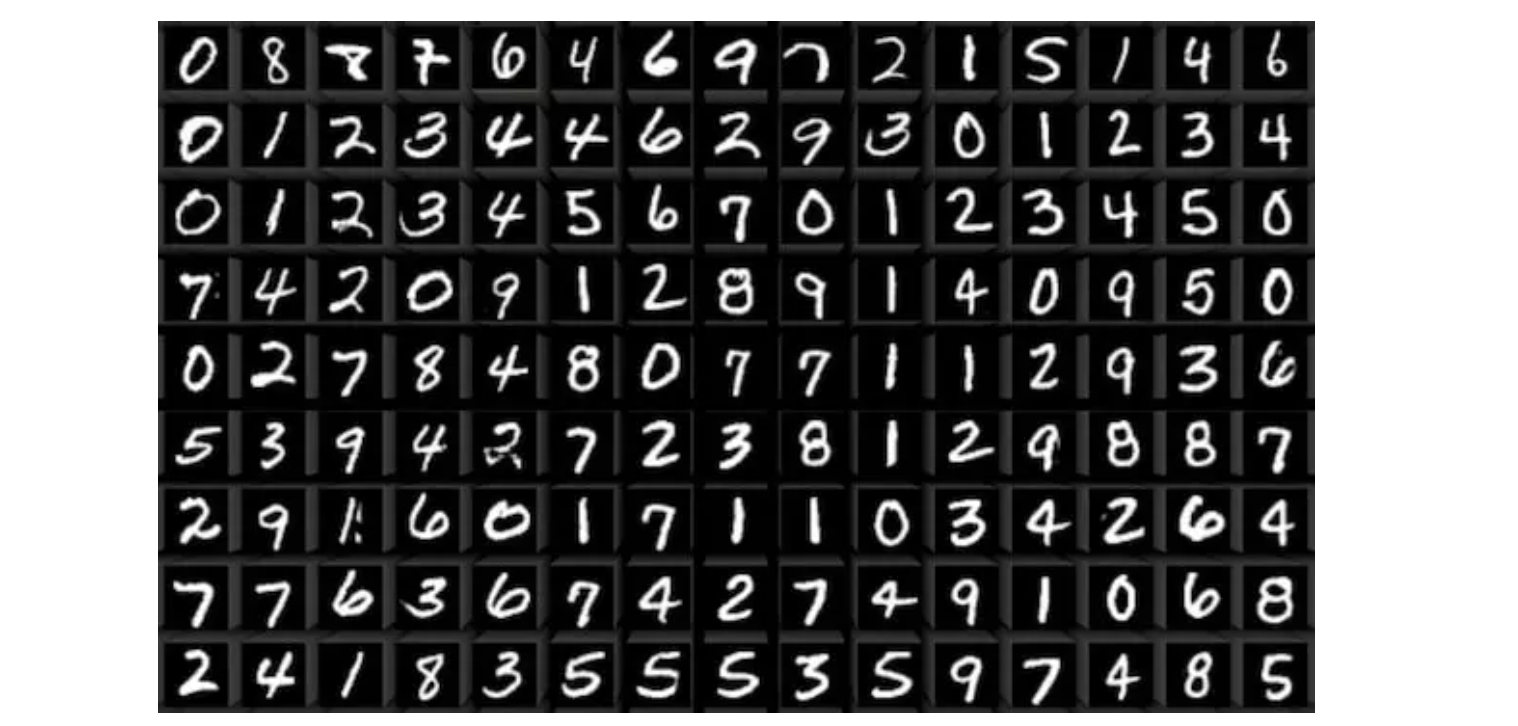

# **Tokenization**
The process of dividing an input image into smaller, non-overlapping patches. Each patch serves as a token that undergoes subsequent processing within the transformer architecture. Localized Feature Representation: Images can be large, and processing them pixel-wise in transformers would be computationally expensive. Using Patches allows transformers to focus on smaller, localized regions, capturing meaningful features efficiently.

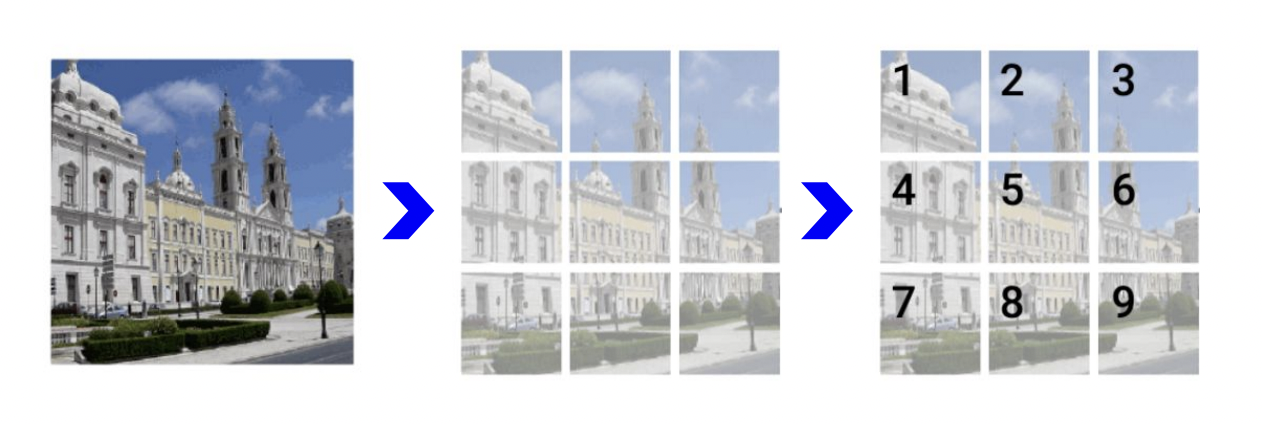

In [ ]:
def patchify(images, n_patches):
    """
    Extracts patches from a batch of images and returns them as a tensor.
    The images are divided into n_patches x n_patches patches.
    The patches are flattened to 1D vectors.
    The patches are stacked along the second dimension (dim=1).

    Args:
        images (torch.Tensor): Batch of images to extract patches from.
        n_patches (int): Number of patches to extract in each dimension.

    Returns:
        torch.Tensor: Tensor containing the patches.
    """


    # Get the dimensions of the images
    num_images, channels, height, width = images.shape

    assert height == width, "Images must be square"

    # Initialize an empty list to store patches
    patches_list = []

    # Loop through patch indices
    for i in range(n_patches):
        for j in range(n_patches):
            # Extract the current patch from each image and flatten it
            patch = images[:, :, i * height // n_patches : (i + 1) * height // n_patches, j * width // n_patches : (j + 1) * width // n_patches].flatten(1)

            # Append the flattened patch to the list
            patches_list.append(patch)

    # Stack the patches along the specified dimension (dim=1)
    patches = torch.stack(patches_list, dim=1)

    return patches

#**Model Architecture**

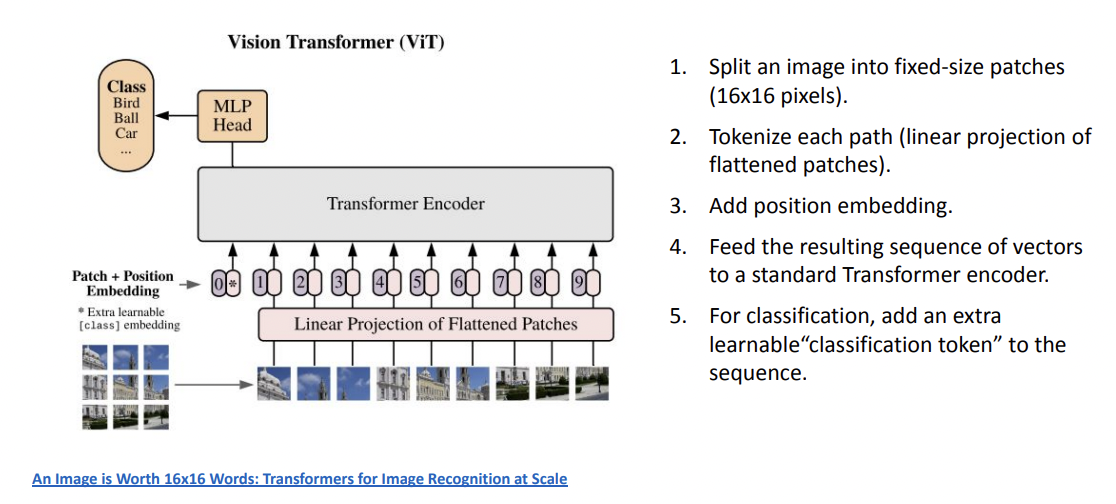

##**Positional Encoding**

In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d))) # The use of 10000 and d is a heuristic that has been found to work well in practice,
                                              ## helping the model to better differentiate positions.
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

##**Attention**

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        """
        Applies multi-head self-attention to input sequences.

        This module takes input sequences and performs multi-head self-attention, allowing the model to
        focus on different parts of the input sequences simultaneously. It consists of linear mappings
        for queries, keys, and values, and employs the scaled dot-product attention mechanism.
        The output is obtained by concatenating and linearly transforming the attention-weighted values.

        Args:
        sequences (torch.Tensor): Input tensor of shape (batch_size, seq_length, d_model).
        mask (torch.Tensor, optional): Mask tensor for ignoring certain elements. Defaults to None.

        Returns:
        torch.Tensor: Output tensor of shape (batch_size, seq_length, d_model).
        """
        super(MultiHeadSelfAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        assert self.head_dim * num_heads == d_model, "Invalid number of heads or d_model dimensions"

        # Linear mappings for queries, keys, and values
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        # Linear mapping for the output
        self.wo = nn.Linear(d_model, d_model)

    def forward(self, sequences, mask=None):
        """
        Forward pass for MultiHeadSelfAttention.

        Args:
            sequences (Tensor): The input tensor of shape (batch_size, seq_length, d_model).
            mask (Tensor, optional): The mask tensor for ignoring certain elements. Defaults to None.

        Returns:
            Tensor: The output tensor of shape (batch_size, seq_length, d_model).
        """
        batch_size, seq_length, _ = sequences.size()

        # Apply linear mappings for queries, keys, and values
        q = self.wq(sequences).view(batch_size, -1, self.num_heads, self.head_dim)
        k = self.wk(sequences).view(batch_size, -1, self.num_heads, self.head_dim)
        v = self.wv(sequences).view(batch_size, -1, self.num_heads, self.head_dim)

        # Transpose dimensions for compatibility with attention computation
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Compute scaled dot-product attention
        attn = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)

        # Apply mask if provided
        if mask is not None:
            attn = attn.masked_fill(mask == 0, float('-inf'))

        # Apply softmax activation to obtain attention weights
        attn = F.softmax(attn, dim=-1)

        # Compute the weighted sum of values
        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Apply linear mapping for the final output
        out = self.wo(out)

        return out

##**ViT Block (Add & Norm, Feed-Forward)**

In [ ]:
class ViTBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, mlp_ratio=4):
        """
        Initialize the ViTBlock module.

        Args:
            hidden_dim (int): The dimensionality of the hidden state.
            num_heads (int): The number of attention heads.
            mlp_ratio (int, optional): The ratio of the hidden dimension in the MLP. Defaults to 4.
        """
        super(ViTBlock, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # Layer normalization for the Multi-Head Self Attention (MHSA) and the MLP
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.mhsa = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.norm2 = nn.LayerNorm(hidden_dim)

        # Multi-Layer Perceptron (MLP) for feature transformation
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, mlp_ratio * hidden_dim),
            nn.GELU(),  # GELU activation function
            nn.Linear(mlp_ratio * hidden_dim, hidden_dim),
        )

    def forward(self, x):
        """
        Forward pass for ViTBlock.

        Args:
            x (Tensor): The input tensor of shape (batch_size, seq_length, hidden_dim).

        Returns:
            Tensor: The output tensor of shape (batch_size, seq_length, hidden_dim).
        """
        # Apply LayerNorm and Multi-Head Self Attention (MHSA)
        mhsa_out = self.mhsa(self.norm1(x))

        # Add the original input to the MHSA output (residual connection)
        out = x + mhsa_out

        # Apply LayerNorm and Multi-Layer Perceptron (MLP)
        mlp_out = self.mlp(self.norm2(out))

        # Add the original input to the MLP output (residual connection)
        out = out + mlp_out

        return out

##**Vision Transformer Encoder**

In [ ]:
class ViT(nn.Module):
    def __init__(self, input_shape, n_patches=7, n_blocks=2, hidden_dim=8, n_heads=2, output_dim=10):
        """
        Initialize the ViT module.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            n_patches (int, optional): Number of patches in each dimension. Defaults to 7.
            n_blocks (int, optional): Number of transformer blocks. Defaults to 2.
            hidden_dim (int, optional): Dimensionality of the hidden state. Defaults to 8.
            n_heads (int, optional): Number of attention heads. Defaults to 2.
            output_dim (int, optional): Dimensionality of the output. Defaults to 10.
        """
        # Super constructor
        super(ViT, self).__init__()

        # Attributes
        self.input_shape = input_shape  # (C, H, W)
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_dim = hidden_dim

        # Input and patches sizes
        assert (input_shape[1] % n_patches == 0), "Input shape not entirely divisible by the number of patches"
        assert (input_shape[2] % n_patches == 0), "Input shape not entirely divisible by the number of patches"

        self.patch_size = (input_shape[1] / n_patches, input_shape[2] / n_patches)

        # 1) Linear mapper
        self.input_dim = int(input_shape[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_dim, hidden_dim)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, hidden_dim))

        # 3) Positional embedding
        self.register_buffer("positional_embeddings",get_positional_embeddings(n_patches**2 + 1, hidden_dim),
            persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([ViTBlock(hidden_dim, n_heads)] * n_blocks)

        # 5) Classification MLP
        self.mlp = nn.Sequential(nn.Linear(hidden_dim, output_dim), nn.Softmax(dim=-1))

    def forward(self, images):
        """
        Forward pass for ViT.

        Args:
            images (Tensor): Batch of input images.

        Returns:
            Tensor: Output category distribution.
        """
        # Dividing images into patches
        batch_size, _, _, _ = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(batch_size, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(batch_size, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution

# **Training**

In [ ]:
# Define Hyperparameters
N_EPOCHS = 5
LR = 0.005
BATCH_SIZE = 128
N_PATCHES = 7
N_BLOCKS = 2
HIDDEN_DIM = 8
N_HEADS = 2
OUTPUT_DIM = 10

In [ ]:
from torchsummaryX import summary

# Model summary
model = ViT((1, 28, 28), N_PATCHES, N_BLOCKS, HIDDEN_DIM, N_HEADS, OUTPUT_DIM).to(device)
summary(model, torch.zeros((1, 1, 28, 28)))

                            Kernel Shape Output Shape Params Mult-Adds
Layer                                                                 
0_linear_mapper                  [16, 8]   [1, 49, 8]  136.0     128.0
1_blocks.0.LayerNorm_norm1           [8]   [1, 50, 8]   16.0       8.0
2_blocks.0.mhsa.Linear_wq         [8, 8]   [1, 50, 8]   72.0      64.0
3_blocks.0.mhsa.Linear_wk         [8, 8]   [1, 50, 8]   72.0      64.0
4_blocks.0.mhsa.Linear_wv         [8, 8]   [1, 50, 8]   72.0      64.0
5_blocks.0.mhsa.Linear_wo         [8, 8]   [1, 50, 8]   72.0      64.0
6_blocks.0.LayerNorm_norm2           [8]   [1, 50, 8]   16.0       8.0
7_blocks.0.mlp.Linear_0          [8, 32]  [1, 50, 32]  288.0     256.0
8_blocks.0.mlp.GELU_1                  -  [1, 50, 32]      -         -
9_blocks.0.mlp.Linear_2          [32, 8]   [1, 50, 8]  264.0     256.0
10_blocks.0.LayerNorm_norm1          [8]   [1, 50, 8]      -       8.0
11_blocks.0.mhsa.Linear_wq        [8, 8]   [1, 50, 8]      -      64.0
12_blo

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_linear_mapper,"[16, 8]","[1, 49, 8]",136.0,128.0
1_blocks.0.LayerNorm_norm1,[8],"[1, 50, 8]",16.0,8.0
2_blocks.0.mhsa.Linear_wq,"[8, 8]","[1, 50, 8]",72.0,64.0
3_blocks.0.mhsa.Linear_wk,"[8, 8]","[1, 50, 8]",72.0,64.0
4_blocks.0.mhsa.Linear_wv,"[8, 8]","[1, 50, 8]",72.0,64.0
5_blocks.0.mhsa.Linear_wo,"[8, 8]","[1, 50, 8]",72.0,64.0
6_blocks.0.LayerNorm_norm2,[8],"[1, 50, 8]",16.0,8.0
7_blocks.0.mlp.Linear_0,"[8, 32]","[1, 50, 32]",288.0,256.0
8_blocks.0.mlp.GELU_1,-,"[1, 50, 32]",NaN,NaN


In [ ]:
 # Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(
        train_loader, desc=f"Epoch {epoch + 1} in training", leave=False
    ):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5 loss: 2.14


Epoch 2 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5 loss: 1.89


Epoch 3 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5 loss: 1.81


Epoch 4 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5 loss: 1.75


Epoch 5 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5 loss: 1.73


# **Testing**

In [ ]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.70
Test accuracy: 76.28%


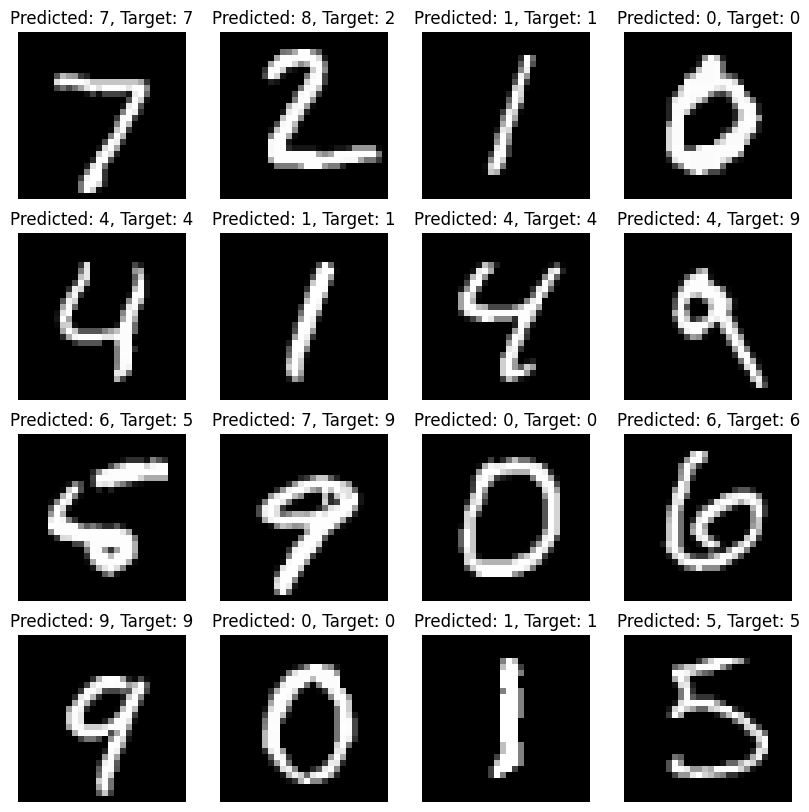

In [ ]:
# Show some predictions
with torch.no_grad():
    x, y = next(iter(test_loader))
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    y_hat = torch.argmax(y_hat, dim=1)

    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(x[i * 4 + j].cpu().view(28, 28), cmap="gray")
            axs[i, j].set_title(f"Predicted: {y_hat[i * 4 + j]}, Target: {y[i * 4 + j]}")
            axs[i, j].axis("off")
    plt.show()